In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install numpy

In [ ]:
!pip install pandas

In [ ]:
#this is the neighbors catalogue
import pandas as pd
df_result = pd.read_hdf('/content/gdrive/MyDrive/neighbors_0.h5') #change the file accordingly

#this part only for testing, comment these lines in prod
df_result = df_result[['11','336','339']]

In [ ]:
!pip install vaex

     |████████████████████████████████| 51kB 2.2MB/s 
     |████████████████████████████████| 102kB 4.2MB/s 
     |████████████████████████████████| 2.4MB 26.4MB/s 
     |████████████████████████████████| 1.2MB 27.8MB/s 
     |████████████████████████████████| 112kB 49.5MB/s 
     |████████████████████████████████| 11.7MB 25.2MB/s 
     |████████████████████████████████| 2.9MB 39.1MB/s 
     |████████████████████████████████| 3.3MB 32.7MB/s 
     |████████████████████████████████| 2.7MB 30.3MB/s 
     |████████████████████████████████| 266kB 41.7MB/s 
     |████████████████████████████████| 3.4MB 31.6MB/s 
     |████████████████████████████████| 276kB 43.1MB/s 
  Created wheel for aplus: filename=aplus-0.11.0-cp37-none-any.whl size=4412 sha256=a73e421cddde528070ed3dc5292a3bd71ca662c4b13926dcce896f5962d4b760
  Stored in directory: /root/.cache/pip/wheels/77/95/8a/ccc1d85d9cabd162a537be5ad77f95d109170df37b49c0ca21
Successfully built aplus


In [ ]:
#load and read the target stars
import vaex
df_vaex = vaex.open('/content/gdrive/MyDrive/neighbors_with_snr.hdf5') #the og

In [ ]:
#match the target with the catalogue
#for example, neighbors_0 is for target 0 - 2000
#df_target = df_vaex[0:2000] #the prod
df_target = df_vaex
df_target = df_target.to_pandas_df()
df_target = df_target.loc[df_target['sobject_id_1'].isin(['170723002601253','170602005201064','170119003101004'])]
df_target = df_target.reset_index() #11, 336, 339

In [ ]:
df_target

,index,sobject_id_1,teff,logg,fe_h,ebv_bstep,snr_c2_iraf
0,11,170723002601253,6363.256348,3.489459,-0.020469,0.956996,10.896493
1,336,170602005201064,7492.299316,2.566358,-0.904851,0.681145,18.090953
2,339,170119003101004,5262.530762,2.493731,0.225894,0.680431,68.616874


In [ ]:
#create catalogue for reading the parameter
df_refer = df_vaex
df_refer =  df_refer.to_pandas_df()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)


#rename the column, comment this line in prod
df_result = df_result.rename(columns={'11': '0', '336': '1', '339': '2'})
df_result[:10]

,0,1,2
157906,nan,nan,nan
157907,nan,nan,nan
157909,nan,nan,nan
157910,nan,nan,nan
157912,nan,nan,nan
157913,nan,nan,nan
157914,nan,nan,nan
157915,nan,nan,nan
157917,nan,nan,nan
157918,nan,nan,nan


In [ ]:
!pip install tqdm

In [ ]:
from astropy.io import fits
from scipy import interpolate
from tqdm import tqdm
import numpy as np
from astropy.table import Table
from astropy.table import QTable

In [ ]:
#collection of function
def wav(c0, c1, x):
    return c0 + (c1*x)

def read_spectra(spectra):
  t_spectra = fits.open(spectra, memmap = True)
  f_obj = t_spectra[4].data #flux of the spectra
  e_obj = t_spectra[1].data #error of flux
  disp_start = t_spectra[4].header['CRVAL1'] - (t_spectra[4].header['CRPIX1'] - 1) * t_spectra[4].header['CDELT1'] #at which wavelength the dispersion starts
  w_obj = wav(disp_start, t_spectra[4].header['CDELT1'], np.linspace(1, len(f_obj), len(f_obj)))
  return w_obj, f_obj, e_obj

def create_model(target_sp, neighbor): #target_sp -> target spectra, neighbor -> list of neighbors
  #read the target spectra
  target_spectra = read_spectra(target_sp)

  w_obj = target_spectra[0]
  f_obj = target_spectra[1]
  e_obj = target_spectra[2]

  if len(neighbor) == 0:
    pass
  else:
    for j in tqdm(range(len(neighbor))):
      spectra = fits.open('/content/gdrive/MyDrive/spectra-test/'+str(neighbor[j])+"2.fits", memmap = True)

      #flux of the neighbor spectra
      f = spectra[4].data 
      
      #wavelength construction
      disp_start = spectra[4].header['CRVAL1'] - (spectra[4].header['CRPIX1'] - 1) * spectra[4].header['CDELT1'] #at which wavelength the dispersion starts
      w = wav(disp_start, spectra[4].header['CDELT1'], np.linspace(1, len(f), len(f)))

      min_wav.append(w[0])
      max_wav.append(w[-1])
    
    min_wav = []
    max_wav = []
  
    #define start and end wavelength based on the neighbors spectra
    nearest_index_max_start_wav = min(range(len(w_obj)), key=lambda i: abs(w_obj[i]-max(min_wav)))
    if w_obj[nearest_index_max_start_wav] < max(min_wav):
      nearest_index_max_start_wav = nearest_index_max_start_wav + 1

    nearest_index_min_end_wav = min(range(len(w_obj)), key=lambda i: abs(w_obj[i]-min(max_wav)))
    if w_obj[nearest_index_min_end_wav] > min(max_wav):
      nearest_index_min_end_wav = nearest_index_min_end_wav - 1

    w_obj = w_obj[nearest_index_max_start_wav:nearest_index_min_end_wav]
    f_obj = f_obj[nearest_index_max_start_wav:nearest_index_min_end_wav]
    e_obj = e_obj[nearest_index_max_start_wav:nearest_index_min_end_wav]

    matrix_of_flux = []

    for j in tqdm(range(len(neighbor))):
      spectra = fits.open('/content/gdrive/MyDrive/spectra-test/'+str(neighbor.values[j])+"2.fits", memmap = True)

      #flux of the neighbor spectra
      f = spectra[4].data 
      
      #wavelength construction
      disp_start = spectra[4].header['CRVAL1'] - (spectra[4].header['CRPIX1'] - 1) * spectra[4].header['CDELT1'] #at which wavelength the dispersion starts
      w = wav(disp_start, spectra[4].header['CDELT1'], np.linspace(1, len(f), len(f)))

      #interpolate to selected range object spectra
      interpolation = interpolate.interp1d(w, f)
      f = interpolation(w_obj)
    
      matrix_of_flux.append(pd.Series(f, name=str(j)))

    result = pd.concat(matrix_of_flux, axis=1)
    result = result.assign(w_obj = w_obj, f_obj = f_obj, e_obj = e_obj, f_mean = result.mean(1), f_stddev = result.std(1))
  
    return result
    #hdu_list = fits.HDUList([
    #                         fits.PrimaryHDU(),
    #                         fits.table_to_hdu(result),
    #fits.table_to_hdu(tb),])
    #hdu_list.writeto('tables_spectra.fits')

def create_table(l_n, l_t):
  #l_n = list of neighbors
  #l_t = list target

  if len(l_n) == 0:
    pass
  else:
    t_spectra = fits.open(path + str(l_t[i])+ "2.fits", memmap = True)
    f_obj = t_spectra[4].data #flux of the spectra
    e_obj = t_spectra[1].data #error of flux
    disp_start = t_spectra[4].header['CRVAL1'] - (t_spectra[4].header['CRPIX1'] - 1) * t_spectra[4].header['CDELT1'] #at which wavelength the dispersion starts
    w_obj = wav(disp_start, t_spectra[4].header['CDELT1'], np.linspace(1, len(f_obj), len(f_obj)))

    min_wav = []
    max_wav = []

    print("target " + str(i))
  
    for j in tqdm(range(len(l_n))):
      #read the file that contains the neighbors
      #print("target " + str(j))
      spectra = fits.open(path + str(l_n[j]) +'2.fits', memmap = True)

      #flux of the spectra
      f = spectra[4].data 
    
      #wavelength construction
      disp_start = spectra[4].header['CRVAL1'] - (spectra[4].header['CRPIX1'] - 1) * spectra[4].header['CDELT1'] #at which wavelength the dispersion starts
      w = wav(disp_start, spectra[4].header['CDELT1'], np.linspace(1, len(f), len(f)))
    
      #append min and max wavelength value
      min_wav.append(w[0])
      max_wav.append(w[-1])

    print("maximum of start wavelength " + str(max(min_wav)))
    print("maximum of end wavelength " + str(min(max_wav)))
    print("------------------------------")

    print('start of w_obj ' + str((w_obj[0])))
    print('end of w_obj ' + str((w_obj[-1])))


    #define start and end wavelength based on the neighbors spectra
    nearest_index_max_start_wav = min(range(len(w_obj)), key=lambda i: abs(w_obj[i]-max(min_wav)))
    if w_obj[nearest_index_max_start_wav] < max(min_wav):
      nearest_index_max_start_wav = nearest_index_max_start_wav + 1

    nearest_index_min_end_wav = min(range(len(w_obj)), key=lambda i: abs(w_obj[i]-min(max_wav)))
    if w_obj[nearest_index_min_end_wav] > min(max_wav):
      nearest_index_min_end_wav = nearest_index_min_end_wav - 1
  
    w_obj = w_obj[nearest_index_max_start_wav:nearest_index_min_end_wav]
    f_obj = f_obj[nearest_index_max_start_wav:nearest_index_min_end_wav]
    e_obj = e_obj[nearest_index_max_start_wav:nearest_index_min_end_wav]

    e_obj = e_obj.tolist()

    matrix_of_flux = []
    for j in tqdm(range(len(l_n))):
      #read the file that contains the neighbors
      #print("target " + str(j))
      spectra = fits.open(path + str(l_n[j]) +'2.fits', memmap = True)
    
      #flux of the spectra
      f = spectra[4].data 
    
      #wavelength construction
      disp_start = spectra[4].header['CRVAL1'] - (spectra[4].header['CRPIX1'] - 1) * spectra[4].header['CDELT1'] #at which wavelength the dispersion starts
      w = wav(disp_start, spectra[4].header['CDELT1'], np.linspace(1, len(f), len(f)))

      #interpolate to selected range object spectra
      interpolation = interpolate.interp1d(w, f)
      f = interpolation(w_obj)
    
      matrix_of_flux.append(pd.Series(f, name=str(i)))
      #print(type(matrix_of_flux))

    result = pd.concat(matrix_of_flux, axis=1)
    result = result.assign(w_obj = w_obj, f_obj = f_obj, e_obj = e_obj, f_mean = result.mean(1), f_stddev = result.std(1))
    #result.to_csv('/content/gdrive/MyDrive/spectra/' + str(df_target.sobject_id_1.values[i])+'2a.csv', columns = ["w_obj", "f_obj", "e_obj","f_mean", "f_stddev"])
    selection = ["w_obj", "f_obj", "e_obj","f_mean", "f_stddev"]
    result_tab = Table(result[selection].values)

    return result_tab


In [ ]:
path = '/content/gdrive/MyDrive/spectra-test/'


n_neighbors = np.zeros((2000,2))
for i in range(3): #+1 from the n of the target
  list_of_neighbors = df_result[str(i)].dropna() #Lan, all
  list_of_neighbors = list_of_neighbors.astype(np.int64)
  list_of_neighbors = list_of_neighbors.tolist()

  n_neighbors[i] = (df_target.sobject_id_1.values[i],len(list_of_neighbors))

  if len(list_of_neighbors) == 0:
    pass
  else:
  #print(list_of_neighbors)
  #print(str(len(list_of_neighbors)))
    t_spectra = fits.open(path + str(df_target.sobject_id_1.values[i])+ "2.fits", memmap = True)
    f_obj = t_spectra[4].data #flux of the spectra
    e_obj = t_spectra[1].data #error of flux
    disp_start = t_spectra[4].header['CRVAL1'] - (t_spectra[4].header['CRPIX1'] - 1) * t_spectra[4].header['CDELT1'] #at which wavelength the dispersion starts
    w_obj = wav(disp_start, t_spectra[4].header['CDELT1'], np.linspace(1, len(f_obj), len(f_obj)))

    min_wav = []
    max_wav = []

    print("target " + str(i))
  
    for j in tqdm(range(len(list_of_neighbors))):
      #read the file that contains the neighbors
      #print("target " + str(j))
      spectra = fits.open(path + str(list_of_neighbors[j]) +'2.fits', memmap = True)
    
      #flux of the spectra
      f = spectra[4].data 
    
      #wavelength construction
      disp_start = spectra[4].header['CRVAL1'] - (spectra[4].header['CRPIX1'] - 1) * spectra[4].header['CDELT1'] #at which wavelength the dispersion starts
      w = wav(disp_start, spectra[4].header['CDELT1'], np.linspace(1, len(f), len(f)))
    
      #append min and max wavelength value
      min_wav.append(w[0])
      max_wav.append(w[-1])

    
    print("maximum of start wavelength " + str(max(min_wav)))
    print("maximum of end wavelength " + str(min(max_wav)))
    print("------------------------------")

    print('start of w_obj ' + str((w_obj[0])))
    print('end of w_obj ' + str((w_obj[-1])))
    
    #define start and end wavelength based on the neighbors spectra
    nearest_index_max_start_wav = min(range(len(w_obj)), key=lambda i: abs(w_obj[i]-max(min_wav)))
    if w_obj[nearest_index_max_start_wav] < max(min_wav):
      nearest_index_max_start_wav = nearest_index_max_start_wav + 1

    nearest_index_min_end_wav = min(range(len(w_obj)), key=lambda i: abs(w_obj[i]-min(max_wav)))
    if w_obj[nearest_index_min_end_wav] > min(max_wav):
      nearest_index_min_end_wav = nearest_index_min_end_wav - 1
  
    w_obj = w_obj[nearest_index_max_start_wav:nearest_index_min_end_wav]
    f_obj = f_obj[nearest_index_max_start_wav:nearest_index_min_end_wav]
    e_obj = e_obj[nearest_index_max_start_wav:nearest_index_min_end_wav]

    e_obj = e_obj.tolist()

    #print(str(i))
    #print(w_obj, f_obj, e_obj)
    #print("----")

    matrix_of_flux = []
    for j in tqdm(range(len(list_of_neighbors))):
      #read the file that contains the neighbors
      #print("target " + str(j))
      spectra = fits.open(path + str(list_of_neighbors[j]) +'2.fits', memmap = True)
    
      #flux of the spectra
      f = spectra[4].data 
    
      #wavelength construction
      disp_start = spectra[4].header['CRVAL1'] - (spectra[4].header['CRPIX1'] - 1) * spectra[4].header['CDELT1'] #at which wavelength the dispersion starts
      w = wav(disp_start, spectra[4].header['CDELT1'], np.linspace(1, len(f), len(f)))

      #interpolate to selected range object spectra
      interpolation = interpolate.interp1d(w, f)
      f = interpolation(w_obj)
    
      matrix_of_flux.append(pd.Series(f, name=str(i)))
      #print(type(matrix_of_flux))
   
    result = pd.concat(matrix_of_flux, axis=1)
    result = result.assign(w_obj = w_obj, f_obj = f_obj, e_obj = e_obj, f_mean = result.mean(1), f_stddev = result.std(1))
    #result.to_csv('/content/gdrive/MyDrive/spectra/' + str(df_target.sobject_id_1.values[i])+'2a.csv', columns = ["w_obj", "f_obj", "e_obj","f_mean", "f_stddev"])
    selection = ["w_obj", "f_obj", "e_obj","f_mean", "f_stddev"]
    result_tab = Table(result[selection].values)
    
    #names = ('col0', 'col1', 'col2', 'col3', 'col4')
    #new_names = ("w_obj", "f_obj", "e_obj","f_mean", "f_stddev")
    #result_tab_new = result_tab.rename_columns(names, new_names)
    #print(result_tab_new)
    
    hdu_list = fits.HDUList([
      fits.PrimaryHDU(),
      fits.table_to_hdu(result_tab),
     #fits.table_to_hdu(tb), 
    ])
    hdu_list.writeto('/content/gdrive/MyDrive/spectra/' + str(df_target.sobject_id_1.values[i])+'2a.fits')
    
    #a : Lan, all SNR
    #b : Lan, SNR > 30
    #c : DR, all
    #d : DR, SNR > 30
print('fin')
np.savetxt('/content/gdrive/MyDrive/spectra/n_neighbors_a.csv', np.c_[n_neighbors], fmt = '%s', delimiter = ',')

  4%|▍         | 11/287 [00:00<00:02, 107.85it/s]

target 0


  3%|▎         | 10/287 [00:00<00:02, 94.74it/s]

maximum of start wavelength 5651.7697937074245
maximum of end wavelength 5870.262798106401
------------------------------
start of w_obj 5648.0361118317705
end of w_obj 5872.002339735559


  0%|          | 0/14 [00:00<?, ?it/s]

target 2
maximum of start wavelength 5650.079288176484
maximum of end wavelength 5870.493895989625
------------------------------
start of w_obj 5648.719893373096
end of w_obj 5872.419122271805


100%|██████████| 14/14 [00:00<00:00, 89.70it/s]


fin


In [ ]:
hdul = fits.open('/content/gdrive/MyDrive/spectra/1701190031010042a.fits')
hdul.info()

Filename: /content/gdrive/MyDrive/spectra/1701190031010042a.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     18   4034R x 5C   [D, D, D, D, D]   


In [ ]:
data_1 = hdul[1].data

In [ ]:
data_1

FITS_rec([(5650.08557853, 0.86742349, 0.01480065, 0.83677582, 0.01439049),
          (5650.14020594, 0.86637319, 0.01480745, 0.86913648, 0.00780788),
          (5650.19483334, 0.87002348, 0.01476139, 0.9068541 , 0.01743848),
          ...,
          (5870.28865343, 0.96116115, 0.01638236, 0.99157057, 0.02008008),
          (5870.34328083, 0.9641173 , 0.0163516 , 1.00221287, 0.01393198),
          (5870.39790824, 0.96750083, 0.01631794, 1.00456486, 0.01071154)],
         dtype=(numpy.record, [('col0', '>f8'), ('col1', '>f8'), ('col2', '>f8'), ('col3', '>f8'), ('col4', '>f8')]))

(0.0, 1.5)

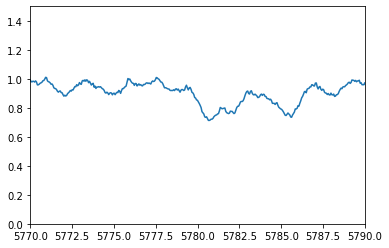

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(data_1['col0'], data_1['col1'])
plt.xlim(5770, 5790)
plt.ylim(0, 1.5)

In [ ]:
#Testing uisng the function to create table
path = '/content/gdrive/MyDrive/spectra-test/'
for i in range(3): #+1 from the n of the target
  list_of_neighbors_ori = df_result[str(i)].dropna() #Lan, all
  #list_of_neighbors = list_of_neighbors_ori.astype(np.int64)
  list_of_neighbors = list_of_neighbors_ori.tolist()

  #refer to the refer table to check wether they meet SNR >= 30 requirement
  df_ln = list_of_neighbors_ori.to_frame()
  df_ln = df_ln.reset_index(drop = True)
  neighbors_table = df_ln.merge(df_refer, left_on=str(i), right_on='sobject_id_1')
  
  #lan30
  


  #ln_lan30 = [x for x in list_of_neighbors if x >= 30]
  #print(ln_lan30)


  #the_result = create_table(list_of_neighbors, df_target.sobject_id_1.values)
  #the_result_lan30 = create_table(ln_lan30, df_target.sobject_id_1.values)

  

========BELOW THIS LINE IS UNCHARTED REGION==========


In [ ]:
neighbors_table

,2,sobject_id_1,teff,logg,fe_h,ebv_bstep,snr_c2_iraf
0,160426003501311,160426003501311,5152,3,0,0,140
1,150829002601255,150829002601255,5120,3,0,0,78
2,170615004901095,170615004901095,5094,3,0,0,102
3,190209001901397,190209001901397,5385,2,0,0,10
4,180101004301359,180101004301359,5135,3,0,0,46
5,171228004202037,171228004202037,5082,3,0,0,326
6,180604003701261,180604003701261,5087,3,0,0,473
7,170805001601163,170805001601163,5075,3,0,0,89
8,171228004202266,171228004202266,5118,3,0,0,117
9,190209001901322,190209001901322,5103,3,0,0,45


In [ ]:
for i in range(500):
  list_of_neighbors = df_result[str(i)].dropna()
  print(str(i))
  print(str(df_target.sobject_id_1.values[i]))
  print(list_of_neighbors)
  print("---")

Streaming output truncated to the last 5000 lines.
349922   170806003201339
350063   170910001801389
Name: 176, Length: 3385, dtype: float64
---
177
170127001601076
157912   170516003601198
157915   140313004701049
157936   140808002101186
157948   150504002401279
157983   170418002701012
               ...      
350087   140807005001024
350124   140316002801073
350142   161008003001071
350174   171003002601125
350191   180102003601271
Name: 177, Length: 6576, dtype: float64
---
178
170710001601346
158088   160418002101048
158361   170615003901349
158445   171104003301362
158666   160330001601018
158866   161107004401023
               ...      
340213   170511000102124
343825   170806001601269
344656   190212003501382
348047   161228002501009
349961   150902002901268
Name: 178, Length: 288, dtype: float64
---
179
160531003601162
157959   140309002602114
157994   140310002701154
157995   170515002101083
158011   140807000601319
158045   160125003501091
               ...      
349922  

In [ ]:
print(str(df_target.sobject_id_1[str(i)]))

KeyError: ignored

In [ ]:
list_of_neighbors = df_result['0'].dropna() #Lan, all
list_of_neighbors = list_of_neighbors.tolist()
create_model(list_of_neighbors, list_of_neighbors)

OSError: ignored

In [ ]:
target_spectra = read_spectra('/content/gdrive/MyDrive/spectra-test/1707230026012532.fits')
target_spectra[0]

array([5648.03611183, 5648.09080444, 5648.14549705, ..., 5871.89295452,
       5871.94764713, 5872.00233974])

In [ ]:
type(result_table)

NameError: ignored

In [ ]:
type(result_tab)

NoneType

In [ ]:
ln_test = [x for x in list_of_neighbors if x >= 30]

In [ ]:
type(list_of_neighbors)

list